# Модель предсказания рейтинга отеля

Датасет содержит сведения об отзывах на отели Европы. Модель должна предсказывать оценку отеля по данным сайта Booking на основе имеющихся в датасете данных. Для оценки качества решения используется результат метрики MAPE.

In [4]:
# Standard python libraries
import os
import time
import re
import ast # безопасное преобразование строк в списки

# Essential DS libraries
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup
from sklearn import preprocessing

import category_encoders as ce
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from geopy.geocoders import Nominatim # разбор адресов, получение коорднат

# Графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Обучение модели  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [5]:
#pip install category_encoders

## Обзор данных

Исходный датасет содержит 17 полей со следующей информацией:

- **hotel_address** — адрес отеля;
- **review_date** — дата, когда рецензент разместил соответствующий отзыв;
- **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- **hotel_name** — название отеля;
- **reviewer_nationality** — страна рецензента;
- **negative_review** — отрицательный отзыв, который рецензент дал отелю;
- **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
- **positive_review** — положительный отзыв, который рецензент дал отелю;
- **review_total_positive_word_counts** — общее количество слов в положительном отзыве.
- **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
- **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
- **total_number_of_reviews** — общее количество действительных отзывов об отеле;
- **tags** — теги, которые рецензент дал отелю;
- **days_since_review** — количество дней между датой проверки и датой очистки;
- **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- **lat** — географическая широта отеля;
- **lng** — географическая долгота отеля.

In [6]:
init_df_hotels = pd.read_csv('./data/hotels_train.csv')
display(init_df_hotels.head())
print(f'Размерность датасета: {init_df_hotels.shape}')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


Размерность датасета: (386803, 17)


In [7]:
init_df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
df_hotels = init_df_hotels.copy()
# Преобразование review_date в тип даты
df_hotels['review_date'] = pd.to_datetime(df_hotels['review_date'], dayfirst=False)
# Преобразование days_since_review
df_hotels['days_since_review'] = df_hotels['days_since_review'].apply(lambda x: str(x).split(' ')[0]).astype('int64')
# Получение списков строковых и числовых признаков
list_str_sign = []
list_num_sign = []
for sign in df_hotels.columns:
    if pd.api.types.is_numeric_dtype(df_hotels[sign].dtype):
        list_num_sign.append(sign)
    elif pd.api.types.is_object_dtype(df_hotels[sign].dtype):
        list_str_sign.append(sign)
print('Числовые признаки:', *list_num_sign, sep='\n')
print('-' * 50)
print('Строковые признаки:', *list_str_sign, sep='\n')


Числовые признаки:
additional_number_of_scoring
average_score
review_total_negative_word_counts
total_number_of_reviews
review_total_positive_word_counts
total_number_of_reviews_reviewer_has_given
reviewer_score
days_since_review
lat
lng
--------------------------------------------------
Строковые признаки:
hotel_address
hotel_name
reviewer_nationality
negative_review
positive_review
tags


## Очистка данных и одномерный анализ

### Удаление полных дубликатов

In [9]:
# Удаление дубликатов
df_hotels = df_hotels.drop_duplicates(ignore_index=True)
print(init_df_hotels.shape[0] - df_hotels.shape[0])

307


В исходных данных присутствовало 307 дублирующих записей.

### Обработка пропусков

In [10]:
# Получение списка признаков с пропусками
cols_null_persent = df_hotels.isnull().mean() * 100
cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633383
lng    0.633383
dtype: float64

Пропуски наблюдаются в географических координатах отеля. Так как адрес отеля заполнен для всех записей, то можно заполнить географические координаты с использованием библиотеки geopy. Если адрес не распознается библиотекой, сокращаем его "масштаб".

In [11]:
def get_coord_by_addr(addr: str):
    ''' Функция возвращает координаты по адресу, если в первичном виде
        адрес не найден, сокращает его и вызывает рекурсивно.
    Args:
        addr (str): Строка, содержащая адрес
    Returns:
        (float, float): Координаты, если полностью адрес не найден, 
        возвращает (0, 0)
    '''
    if addr == '':
        return (0, 0)
    geolocator = Nominatim(user_agent="geo_expert")
    location = geolocator.geocode(addr, timeout=10)
    if location:
        return (location.latitude, location.longitude)
    else:
        addr = addr.split(' ')
        addr = ' '.join(addr[1:])
        return get_coord_by_addr(addr)


# Получение списка адресов без координат
list_loss_addr = list(df_hotels[df_hotels['lat'].isnull()]['hotel_address'].drop_duplicates())
# Получение словаря с координатами по адресам
dict_loss_addr = {}
for addr in list_loss_addr:
    dict_loss_addr[addr] = get_coord_by_addr(addr)

Пропущенные значения заполняются из полученного словаря.

In [12]:
# Заполнение пропущенных значений
df_hotels['lat'] = df_hotels.apply(lambda x: dict_loss_addr.get(x['hotel_address'], (np.NaN, np.NaN))[0] if pd.isna(x['lat']) else x['lat'], axis=1)
df_hotels['lng'] = df_hotels.apply(lambda x: dict_loss_addr.get(x['hotel_address'], (np.NaN, np.NaN))[1] if pd.isna(x['lng']) else x['lng'], axis=1)

# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df_hotels.isnull().sum().sum()}')

Количество пропущенных значений: 0


Все пропущенные значения заполнены.

### Обзор выбросов

In [13]:
# Расшифровка признаков
dict_col_name_rus = {'hotel_address': 'Адрес отеля',
                     'review_date': 'Дата отзыва',
                     'average_score': 'Средний балл отеля за последний год',
                     'hotel_name': 'Название отеля',
                     'reviewer_nationality': 'Страна рецензента',
                     'negative_review': 'Отрицательный отзыв рецензента',
                     'review_total_negative_word_counts': 'Общее количество слов отрицательного отзыва',
                     'positive_review': 'Положительный отзыв рецензента',
                     'review_total_positive_word_counts': 'Общее количество слов положительного отзыва',
                     'reviewer_score': 'Оценка рецензента',
                     'total_number_of_reviews_reviewer_has_given': 'Количество отзывов отеля',
                     'total_number_of_reviews': 'Общее количество действительных отзывов отеля',
                     'tags': 'Теги из отзыва',
                     'days_since_review': 'Количество дней между датой проверки и датой очистки',
                     'additional_number_of_scoring': 'Количество действительных оценок без проверки',
                     'lat': 'Географическая широта отеля',
                     'lng': 'Географическая долгота отеля'}

#### Числовые признаки

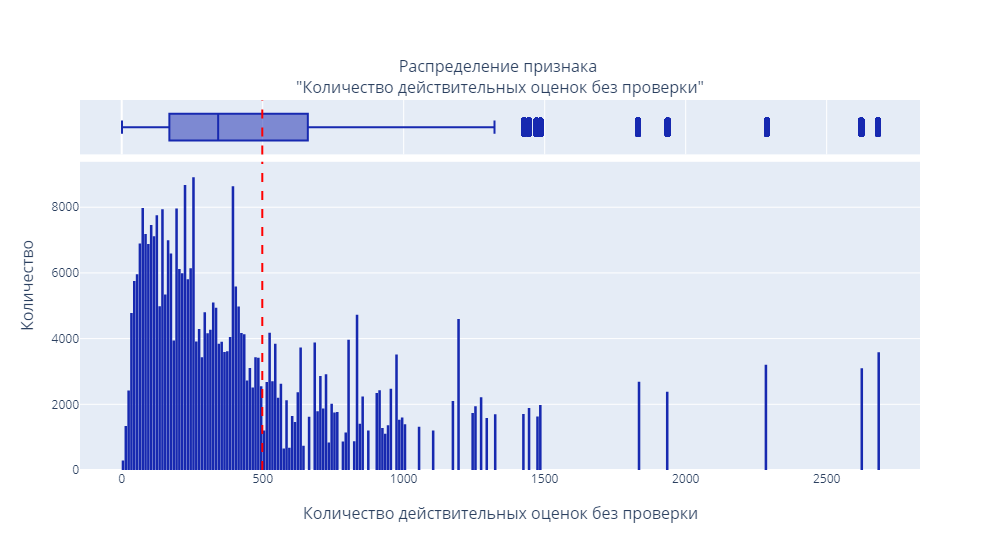

Статистические данные признака:


count    386496.00
mean        498.50
std         500.37
min           1.00
25%         169.00
50%         342.00
75%         660.00
max        2682.00
Name: additional_number_of_scoring, dtype: float64

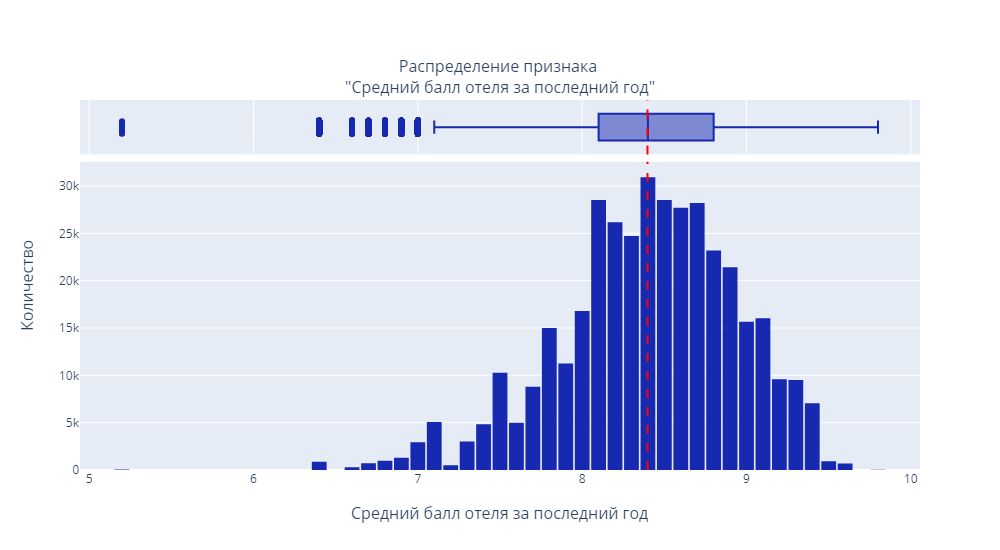

Статистические данные признака:


count    386496.00
mean          8.40
std           0.55
min           5.20
25%           8.10
50%           8.40
75%           8.80
max           9.80
Name: average_score, dtype: float64

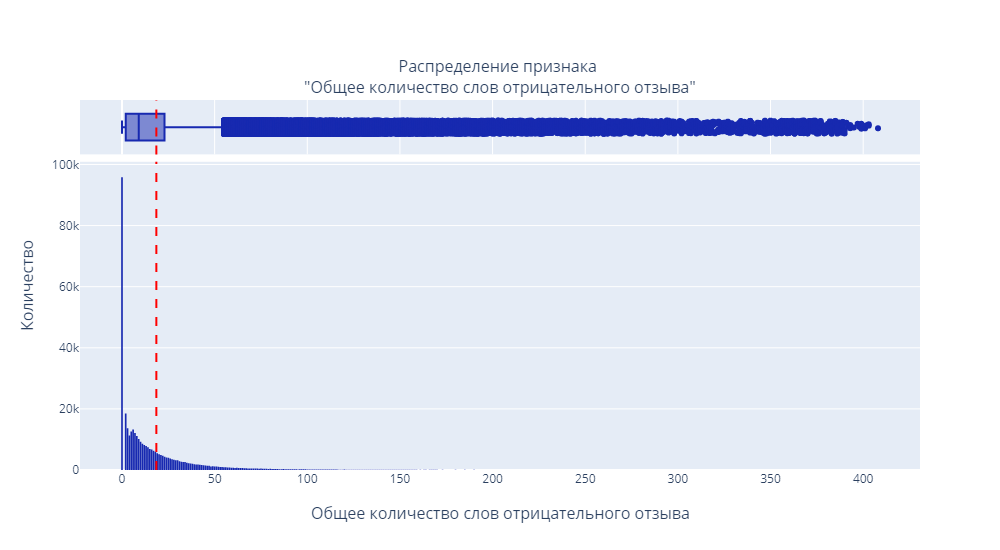

Статистические данные признака:


count    386496.00
mean         18.54
std          29.70
min           0.00
25%           2.00
50%           9.00
75%          23.00
max         408.00
Name: review_total_negative_word_counts, dtype: float64

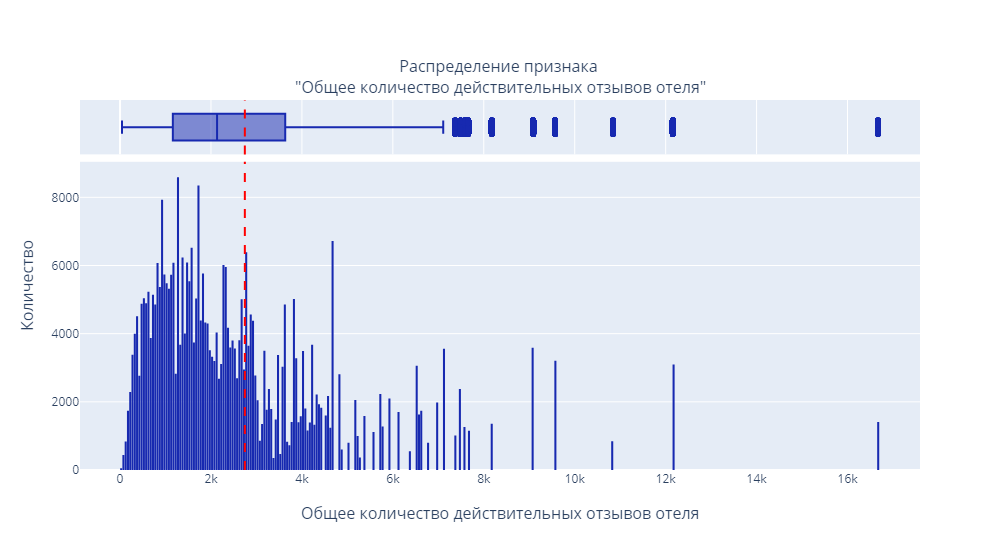

Статистические данные признака:


count    386496.00
mean       2744.68
std        2316.93
min          43.00
25%        1161.00
50%        2134.00
75%        3633.00
max       16670.00
Name: total_number_of_reviews, dtype: float64

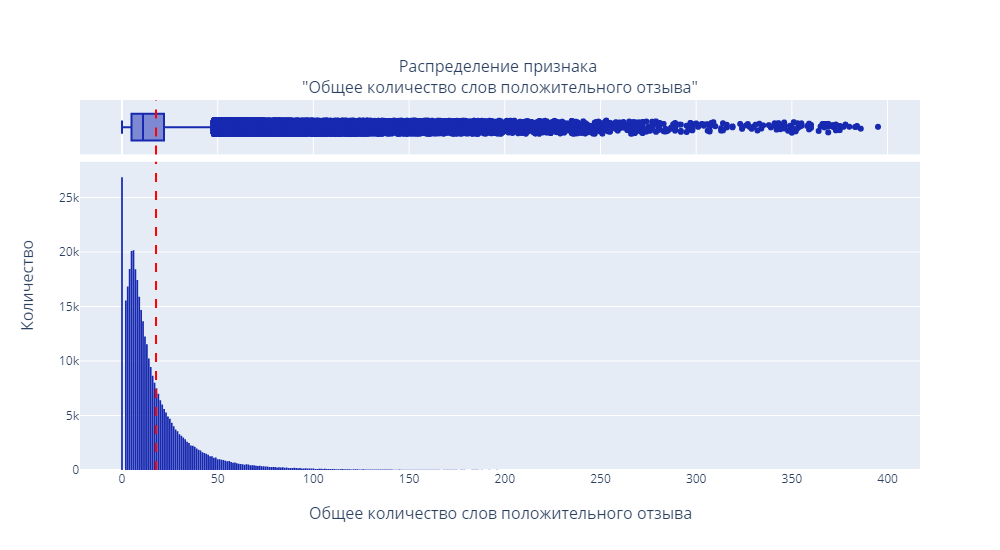

Статистические данные признака:


count    386496.00
mean         17.78
std          21.72
min           0.00
25%           5.00
50%          11.00
75%          22.00
max         395.00
Name: review_total_positive_word_counts, dtype: float64

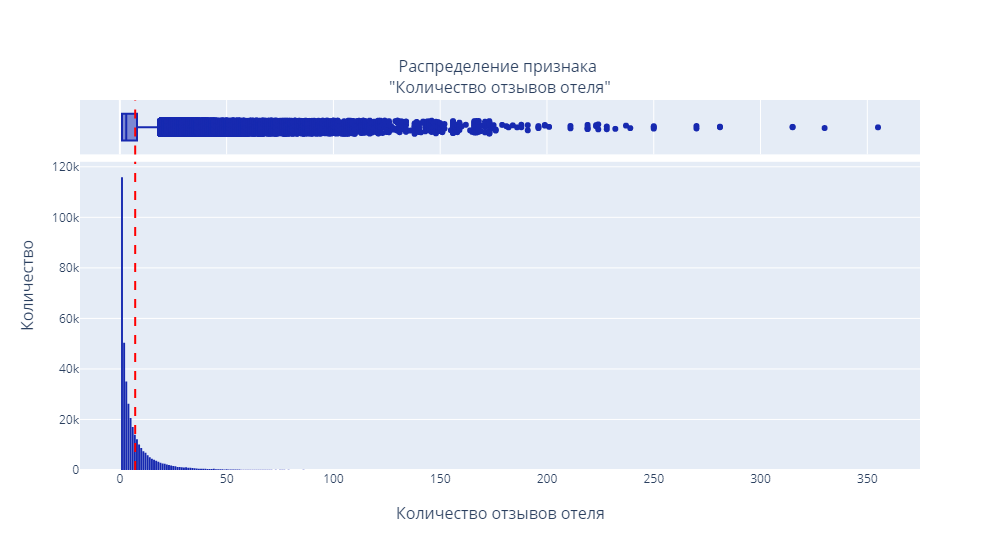

Статистические данные признака:


count    386496.00
mean          7.18
std          11.05
min           1.00
25%           1.00
50%           3.00
75%           8.00
max         355.00
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

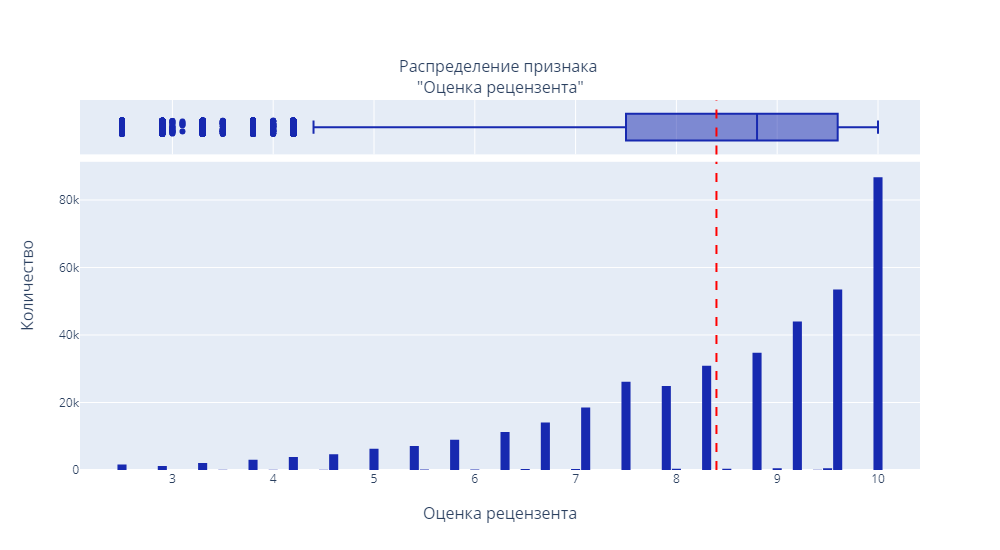

Статистические данные признака:


count    386496.00
mean          8.40
std           1.64
min           2.50
25%           7.50
50%           8.80
75%           9.60
max          10.00
Name: reviewer_score, dtype: float64

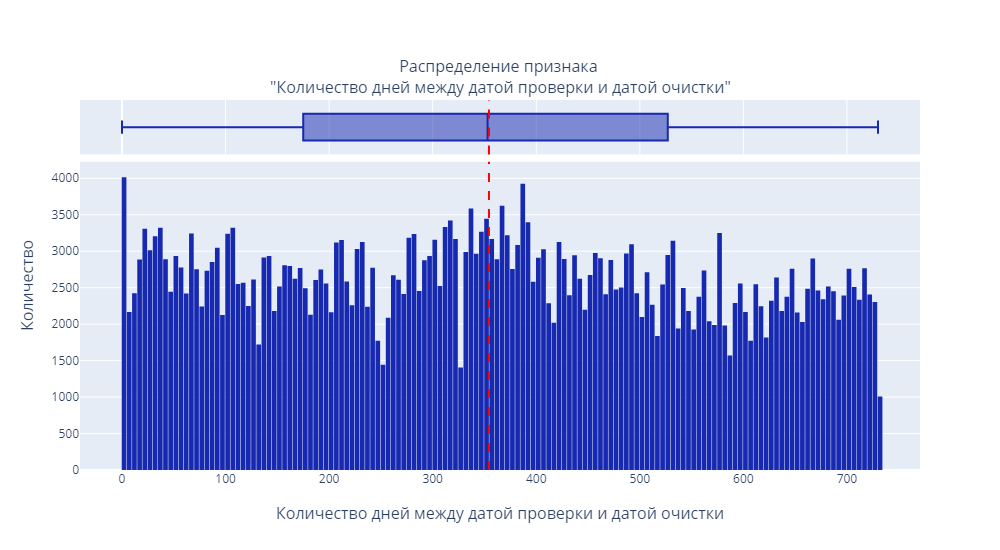

Статистические данные признака:


count    386496.00
mean        354.34
std         208.96
min           0.00
25%         175.00
50%         353.00
75%         527.00
max         730.00
Name: days_since_review, dtype: float64

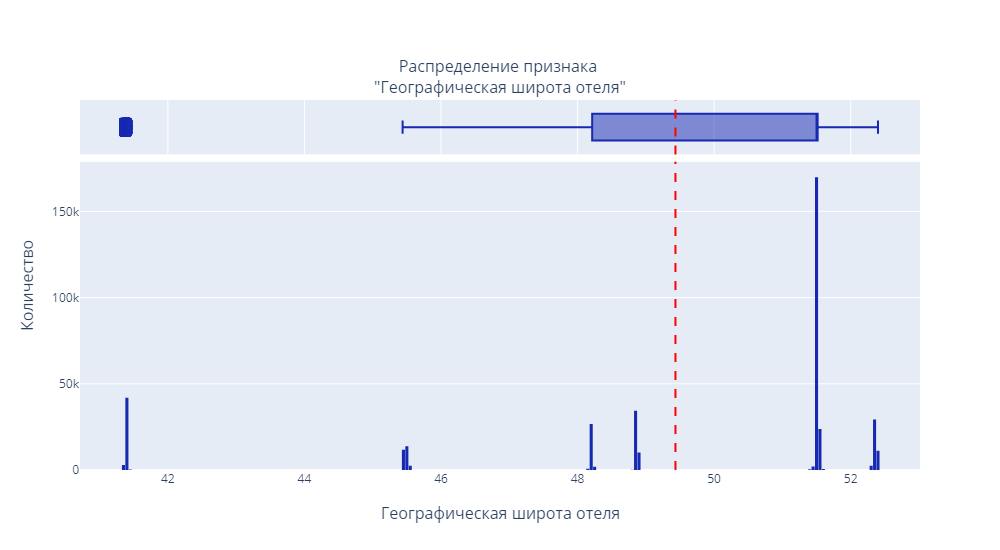

Статистические данные признака:


count    386496.00
mean         49.43
std           3.46
min          41.33
25%          48.21
50%          51.50
75%          51.52
max          52.40
Name: lat, dtype: float64

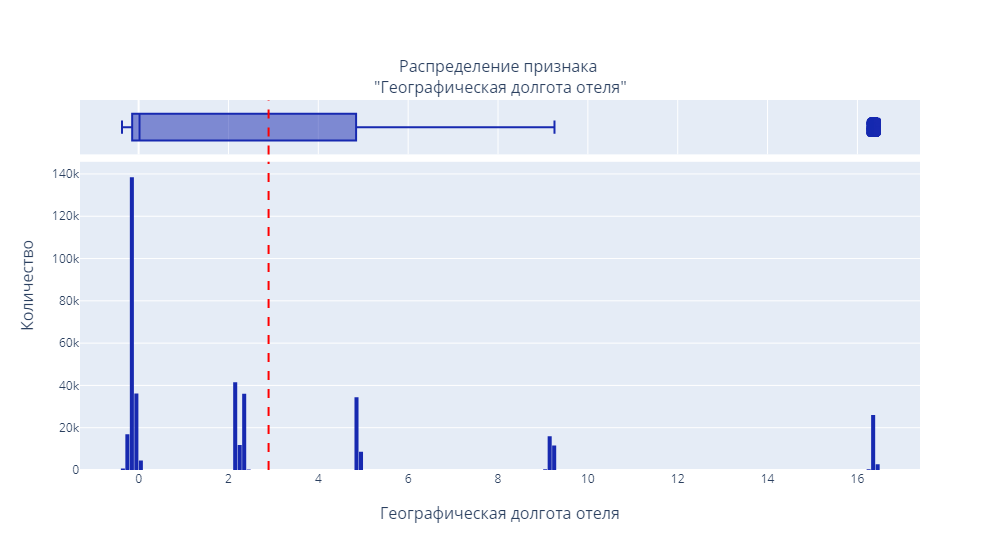

Статистические данные признака:


count    386496.00
mean          2.89
std           4.67
min          -0.37
25%          -0.14
50%           0.02
75%           4.84
max          16.46
Name: lng, dtype: float64

In [14]:
# Построение гистограммы распределения каждого числового признака
for col in list_num_sign:
    # Инициализация полотна на два графика с общей осью X
    fig_col = make_subplots(rows=2, cols=1,
                            shared_xaxes=True, # Общая ось Х
                            x_title=dict_col_name_rus[col],
                            y_title='Количество',
                            row_heights=[0.15, 0.85], # Относительная высота полотен
                            subplot_titles=(f"Распределение признака <br>\"{dict_col_name_rus[col]}\"", ""),
                            vertical_spacing=0.02) # Высота разделителя
    # Построение коробчатой диаграммы
    fig_col.add_trace(go.Box(x=df_hotels[col],
                             marker_color = '#1729B0', # Цвет маркера
                             jitter=0.5, # Разнос точек выбросов по вертикали
                             name='',
                             showlegend=False),
                      row=1, col=1)
    # Построение гистограммы
    fig_col.add_trace(go.Histogram(x=df_hotels[col],
                                   marker_color = '#1729B0', # Цвет маркера
                                   name=dict_col_name_rus[col], # Название набора данных
                                   showlegend=False),
                      row=2, col=1)
    # Построение линии среднего значения
    fig_col.add_vline(x=df_hotels[col].mean(),
                      line=dict(color="Red", dash='dash')) # Стиль линии
    # Размер полотна
    fig_col.update_layout(autosize = False, width = 1000, height = 550,
                          bargap=0.1) # Расстояние между столбцами гистограммы
    fig_col.show('png')
    
    print('Статистические данные признака:')
    display(df_hotels[col].describe().round(2))

**Количество действительных оценок без проверки**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 498.5;
- медиана 342;
- признак распределен в пределах от 1 до 2682.

**Средний балл отеля за последний год**:
- распределение близко к ***нормальному***;
- среднее значение 8.4;
- медиана 8.4;
- признак распределен в пределах от 5.2 до 9.8.

**Общее количество слов отрицательного отзыва**:
- распределение *ненормальное* (экспоненциальное с разрывом);
- среднее значение 18.54;
- медиана 9;
- признак распределен в пределах от 0 до 408.

**Общее количество действительных отзывов отеля**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 2744.68;
- медиана 2134;
- признак распределен в пределах от 43 до 16670.

**Общее количество слов положительного отзыва**:
- распределение *ненормальное* (при отсечке 0-го значения, отсеченного от основного распределения, приближено к пуассоновскому);
- среднее значение 17.78;
- медиана 11;
- признак распределен в пределах от 0 до 395.

**Количество отзывов отеля**:
- распределение *ненормальное* (приближено к экспоненциальному);
- среднее значение 7.18;
- медиана 3;
- признак распределен в пределах от 1 до 355.

**Оценка рецензента**:
- распределение *ненормальное* с множественными пиками (приближено к экспоненциальному со сдвигом);
- среднее значение 8.4;
- медиана 8.8;
- признак распределен в пределах от 2.5 до 10.

**Количество дней между датой проверки и датой очистки**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 354.34;
- медиана 353;
- признак распределен в пределах от 0 до 730.

**Географическая широта отеля**:
- распределение *ненормальное*, разбитое на шесть групп;
- среднее значение 49.43;
- медиана 51.50;
- признак распределен в пределах от 41.33 до 52.40.

**Географическая долгота отеля**:
- распределение *ненормальное*, разбитое на пять групп;
- среднее значение 2.89;
- медиана 0.02;
- признак распределен в пределах от -0.37 до 16.46.

#### Категориальные признаки

Обзор статистики категориальных признаков.

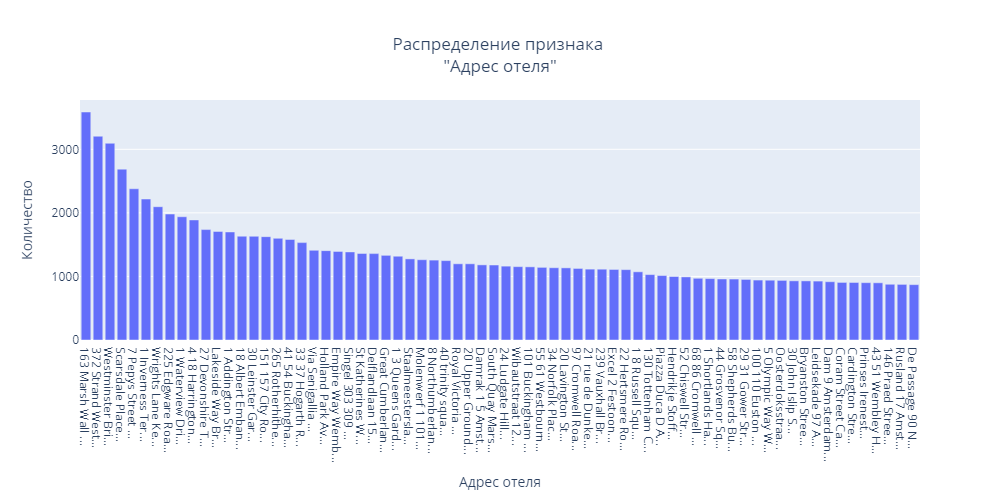

Статистические данные признака:


count                                                386496
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   3587
Name: hotel_address, dtype: object

Top-10 значений (%):


hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              0.93
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     0.83
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     0.80
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    0.70
7 Pepys Street City of London London EC3N 4AF United Kingdom                      0.62
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              0.57
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  0.54
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 0.51
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        0.50
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      0.49
Name: proportion, dtype: float64

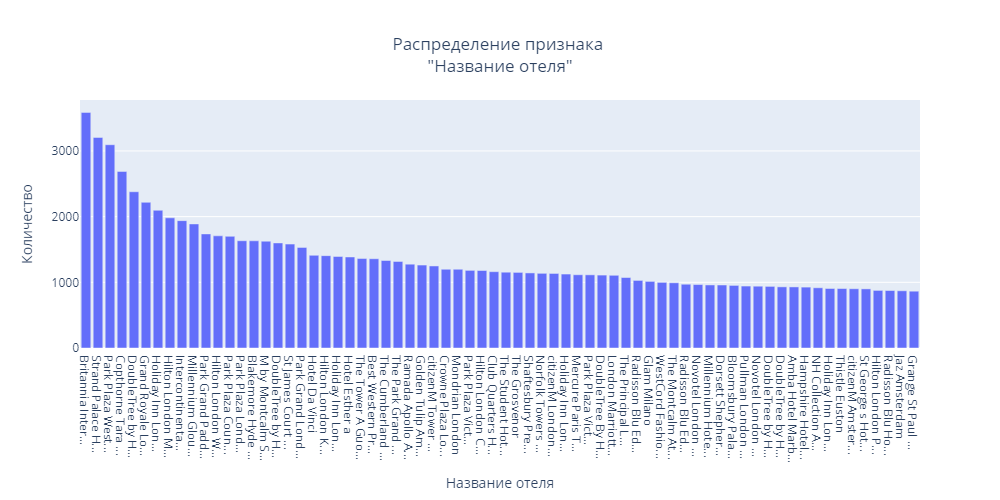

Статистические данные признака:


count                                         386496
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

Top-10 значений (%):


hotel_name
Britannia International Hotel Canary Wharf           0.93
Strand Palace Hotel                                  0.83
Park Plaza Westminster Bridge London                 0.80
Copthorne Tara Hotel London Kensington               0.70
DoubleTree by Hilton Hotel London Tower of London    0.62
Grand Royale London Hyde Park                        0.57
Holiday Inn London Kensington                        0.54
Hilton London Metropole                              0.51
Intercontinental London The O2                       0.50
Millennium Gloucester Hotel London                   0.49
Name: proportion, dtype: float64

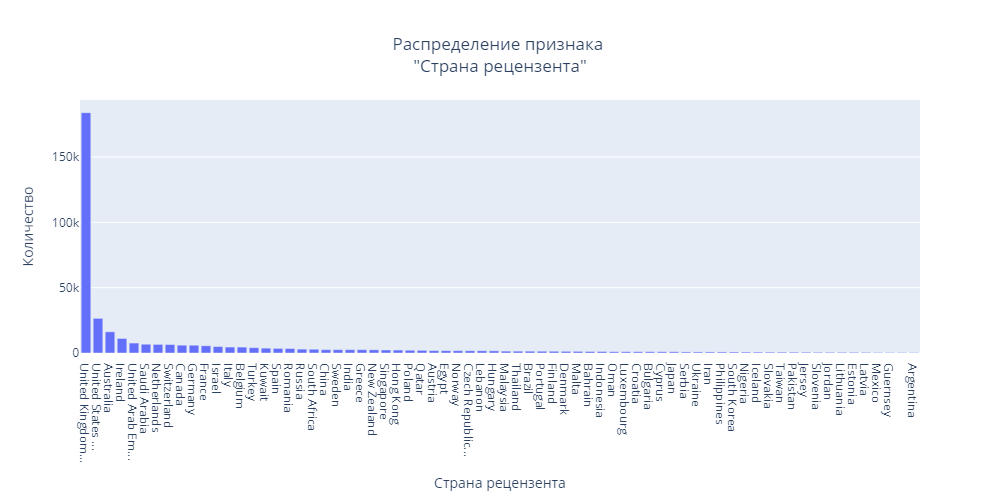

Статистические данные признака:


count               386496
unique                 225
top        United Kingdom 
freq                183952
Name: reviewer_nationality, dtype: object

Top-10 значений (%):


reviewer_nationality
United Kingdom               47.59
United States of America      6.85
Australia                     4.20
Ireland                       2.88
United Arab Emirates          1.97
Saudi Arabia                  1.74
Netherlands                   1.71
Switzerland                   1.68
Canada                        1.55
Germany                       1.54
Name: proportion, dtype: float64

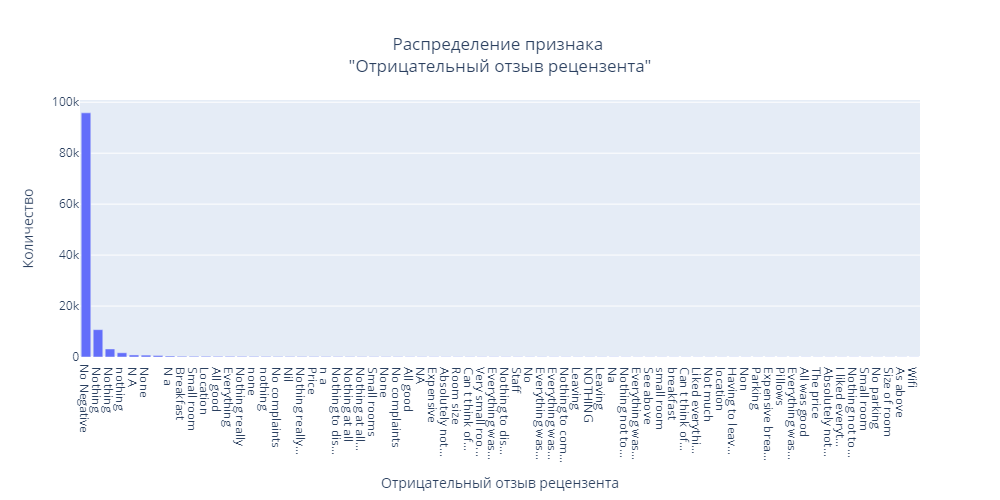

Статистические данные признака:


count          386496
unique         248828
top       No Negative
freq            95833
Name: negative_review, dtype: object

Top-10 значений (%):


negative_review
No Negative    24.80
 Nothing        2.78
 Nothing        0.82
 nothing        0.43
 N A            0.21
 None           0.19
                0.16
 N a            0.10
 Breakfast      0.08
 Small room     0.07
Name: proportion, dtype: float64

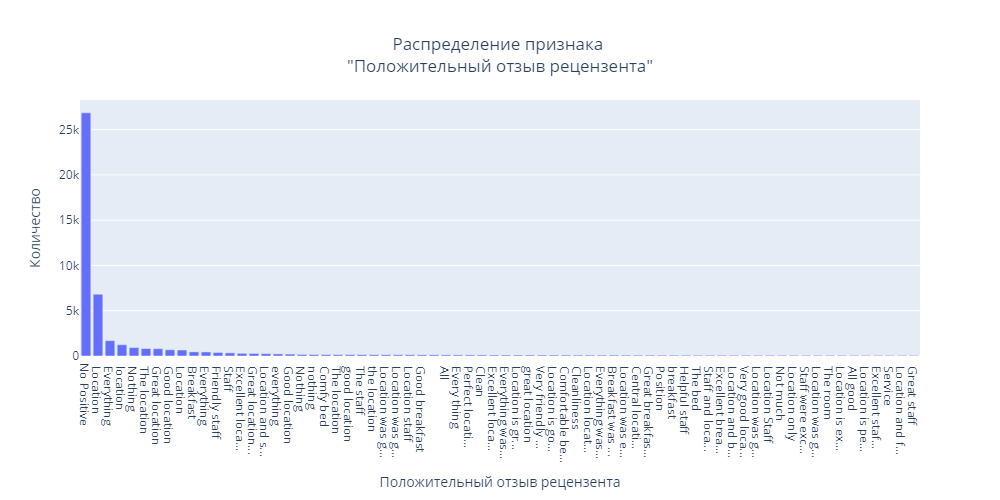

Статистические данные признака:


count          386496
unique         311737
top       No Positive
freq            26863
Name: positive_review, dtype: object

Top-10 значений (%):


positive_review
No Positive        6.95
 Location          1.77
 Everything        0.44
 location          0.32
 Nothing           0.24
 The location      0.21
 Great location    0.21
 Good location     0.18
 Location          0.17
 Breakfast         0.12
Name: proportion, dtype: float64

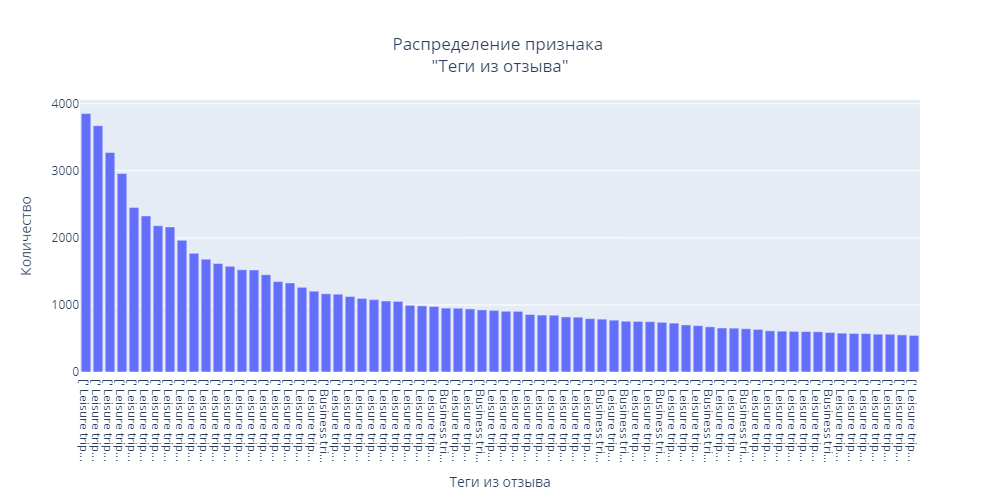

Статистические данные признака:


count                                                386496
unique                                                47135
top       [' Leisure trip ', ' Couple ', ' Double Room '...
freq                                                   3853
Name: tags, dtype: object

Top-10 значений (%):


tags
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              1.00
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     0.95
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     0.85
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       0.77
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             0.63
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    0.60
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  0.56
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    0.56
[' Leisure trip ', 

In [15]:
# Построение баров распределения каждого категориального признака
for col in list_str_sign:
    # Подготовка данных
    count_bar = 70
    len_xtext = 15
    df_tmp = df_hotels[col].value_counts().reset_index()
    df_tmp[col] = df_tmp[col].apply(lambda x: x[:len_xtext]+'...' if len(x) > len_xtext else x)
    # Инициализация полотна
    fig_col = go.Figure(data=go.Bar(x=df_tmp[col].head(count_bar).index,
                                    y=df_tmp['count'].head(count_bar)))
    
    # Размер полотна
    fig_col.update_layout(autosize = False, width = 1000, height = 500)
    # Заголовок диаграммы
    fig_col.update_layout(title=f"Распределение признака <br>\"{dict_col_name_rus[col]}\"",
                          title_x=0.5, # Расположение посередине
                          xaxis_title=dict_col_name_rus[col], # Подпись Х
                          yaxis_title='Количество', # Подпись Y
                          xaxis=dict(tickvals=df_tmp[col].head(count_bar).index, # Оригинальные значения для оси X
                                     ticktext=df_tmp[col].head(count_bar))) # Новые подписи для оси X                   
    fig_col.show('png')
    
    print('Статистические данные признака:')
    display(df_hotels[col].describe())
    print('Top-10 значений (%):')
    display(df_hotels[col].value_counts(normalize=True).head(10).round(4)*100)

Признаки **Адрес отеля** (1493 уникальных значения) и **Название отеля** (1494 уникальных значения) сходны и в совокупности идентифицируют исследуемые объекты. При этом среди них выявлено расхождение, рассмотрим его подробнее ниже.  

**Страна рецензента** содержит 225 уникальных значений, United Kingdom - мода распределения (47.59% записей).  

**Отрицательный отзыв рецензента** содержит 248828 уникальных значений, No Negative - мода распределения (24.8% записей), при этом в признаке присутствуют другие значения, сходные с модой по смыслу.  

**Положительный отзыв рецензента** содержит 311737 уникальных значений, No Positive - мода распределения (6.95% записей), при этом в признаке присутствуют другие значения, сходные с модой по смыслу.  

Признак **Теги отзыва** содержит 47135 уникальных значений, при этом даже мода включает в себя только 1% записей, по своей структуре требует дополнительного анализа преобразования.

#### Признаки в формате даты и времени

In [16]:
print(f'Статистические данные признака "{dict_col_name_rus["review_date"]}":')
display(df_hotels['review_date'].describe())
print('Top-5 значений (%):')
display(df_hotels['review_date'].value_counts(normalize=True).head(5).round(4)*100)

Статистические данные признака "Дата отзыва":


count                           386496
mean     2016-08-13 15:51:21.147540736
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

Top-5 значений (%):


review_date
2017-08-02    0.49
2016-09-15    0.45
2017-04-05    0.44
2016-08-30    0.38
2016-02-16    0.38
Name: proportion, dtype: float64

Признак **Дата отзыва** распределен в пределах от 2015-08-04 до 2017-08-03, выборка включает в себя отзывы за два года.

#### Очистка от выбросов

In [17]:
def outliers_z_score_mod(data,
                         feature, 
                         log_scale=False,
                         left=3,
                         right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned


['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
             'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
             'days_since_review', 'lat', 'lng', 'tags_count', 'stayed_nights', 'reviewer_score']

'''_, df_hotels = outliers_z_score_mod(df_hotels, 'additional_number_of_scoring', log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'average_score', log_scale=True, left=3.5, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_negative_word_counts', log_scale=True, left=3, right=4)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews', log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_positive_word_counts', log_scale=True, left=3, right=4)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews_reviewer_has_given', log_scale=True, left=3, right=4)'''

_, df_hotels = outliers_z_score_mod(df_hotels, 'additional_number_of_scoring', log_scale=True, left=3, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'average_score', log_scale=True, left=3, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_negative_word_counts', log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews', log_scale=True, left=3, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_positive_word_counts', log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews_reviewer_has_given', log_scale=True, left=3, right=3.5)

print(f'Результирующее число записей: {df_hotels.shape[0]}')

Результирующее число записей: 381273


### Отбор неинформативных признаков

In [18]:
low_information_sign = []
for col in list_str_sign:
    top_freq = df_hotels[col].value_counts(normalize=True).max()
    nunique_ratio = df_hotels[col].nunique()/df_hotels[col].count()
    if top_freq > 0.95:
        low_information_sign.append(col)
        print(f'В признаке "{dict_col_name_rus[col]}" одно уникальное значение')
    if nunique_ratio > 0.95:
        low_information_sign.append(col)
        print(f'В признаке "{dict_col_name_rus[col]}" большинство значений уникальны')
if len(low_information_sign) == 0:
    print('Неинформативные признаки отсутствуют')

Неинформативные признаки отсутствуют


Полностью неинформативные признаки отсутствуют.

### Преобразование и генерация признаков

#### Признаки "Название отеля" и "Адрес отеля"

В данных о наименовании отелей и их адресах выявлено расхождение, рассмотрим его подробнее.

In [19]:
# Вычисление несоответствия
df_tmp = df_hotels[['hotel_name', 'hotel_address']].copy()
df_tmp.drop_duplicates(inplace=True)
display(df_tmp['hotel_name'].value_counts(sort=True).head(5))
display(df_tmp['hotel_address'].value_counts(sort=True).head(5))

hotel_name
Hotel Regina                           3
The May Fair Hotel                     1
Catalonia Barcelona Plaza              1
Best Western Premier Kaiserhof Wien    1
Crowne Plaza Paris R publique          1
Name: count, dtype: int64

hotel_address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    2
Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom     1
24 27 Bedford Place Bloomsbury Camden London WC1B 5JH United Kingdom          1
10 Place De La R publique 11th arr 75011 Paris France                         1
153 Rue De Vaugirard 15th arr 75015 Paris France                              1
Name: count, dtype: int64

В датасете имеются наименования отелей с одним адресом и несколько отелей с разными адресами и одинаковым названием.

In [20]:
print(df_tmp[df_tmp['hotel_name'] == 'Hotel Regina'].to_string())
print(df_tmp[df_tmp['hotel_address'] == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'].to_string())

        hotel_name                                               hotel_address
479   Hotel Regina                  Bergara 2 4 Eixample 08002 Barcelona Spain
1428  Hotel Regina         Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria
1566  Hotel Regina  Via Cesare Correnti 13 Milan City Center 20123 Milan Italy
                               hotel_name                                                               hotel_address
451         The Grand at Trafalgar Square  8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom
868  Club Quarters Hotel Trafalgar Square  8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom


Так как несколько отелей могут находиться по одному адресу, а также встречаются отели с одинаковым названием, но в разных городах и странах целесообразно из адреса отеля выделить страну и город как отдельные признаки, а также для однозначной идентификации отеля создать идентификационный признак, объединив название отеля, страну и город, исходные признаки удалить. Признак города представить в формате Страна_город для однозначной идентификации городов.

In [21]:
# Получение полного списка стран
url = 'https://textlists.info/geography/countries-of-the-world/'
response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
countries_all = str(page.find('pre').text).strip().split('\r\n')
print(countries_all)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Republic of the', 'Congo, Democratic Republic of the', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor (Timor-Leste)', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India'

В адресах отелей страна указывается последней, перед ней город, но в адресах United Kingdom между ними фигурирует индекс, удаляем его через регулярное выражение.

In [22]:
# Извлечение из адреса отеля страны и города
def get_country_city(address: str):
    ''' Функция возвращает строку в формате "страна, город",
        извлеченную из полного адреса.
    Args:
        address (str): Полный адрес.
    Returns:
        str: Строка в формате "страна, город", если извлечь
             эти данные не удается, возвращает "unknown, unknown".
    '''
    reg = r'\b([A-Z]{1,2}\d[A-Z\d]? \d[A-Z]{2})\b'
    address = re.sub(reg, '', address)
    country = None
    city = None
    address = address.strip()
    for cntr in countries_all:
        if address.endswith(cntr):
            country = cntr
            city = address[:-len(cntr)].split()[-1]
            return country + ', ' + city
    return 'unknown, unknown'


# Создание признаков страны, города, преобразование имени отеля
df_hotels['country_city'] = df_hotels['hotel_address'].apply(get_country_city)
df_hotels['country'] = df_hotels['country_city'].apply(lambda x: x.split(', ')[0])
df_hotels['hotel_name'] = df_hotels['hotel_name'] + ' (' + df_hotels['country_city'] + ')'

In [23]:
# Получение количества записей с нераспознанными страной/городом
print(f"Нераспознанных стран: {df_hotels[df_hotels['country'] == 'unknown'].shape[0]}")
print(f"Нераспознанных стран_городов: {df_hotels[df_hotels['country_city'].str.contains('unknown')].shape[0]}")

Нераспознанных стран: 0
Нераспознанных стран_городов: 0


In [24]:
print(df_hotels[['hotel_name', 'country', 'country_city']].describe())

                                               hotel_name         country  \
count                                              381273          381273   
unique                                               1388               6   
top     Britannia International Hotel Canary Wharf (Un...  United Kingdom   
freq                                                 3587          193553   

                  country_city  
count                   381273  
unique                       6  
top     United Kingdom, London  
freq                    193553  


In [25]:
display(df_hotels[['country', 'country_city']].value_counts())

country         country_city          
United Kingdom  United Kingdom, London    193553
Spain           Spain, Barcelona           44940
France          France, Paris              43293
Netherlands     Netherlands, Amsterdam     42748
Austria         Austria, Vienna            29047
Italy           Italy, Milan               27692
Name: count, dtype: int64

В датасете представлены данные из шести городов шести разных стран, из результирующей тренировочной выборки один из признаков можно исключить.

#### Признак "Страна рецензента"

При рассмотрении страны рецензента мы можем сравнить ее со страной отеля и вывести признак **Зарубежный гость** ('foreign_guest').

In [26]:
df_hotels['reviewer_nationality'] = df_hotels['reviewer_nationality'].str.strip()
df_hotels['foreign_guest'] = np.where(df_hotels['country'] != df_hotels['reviewer_nationality'], True, False)

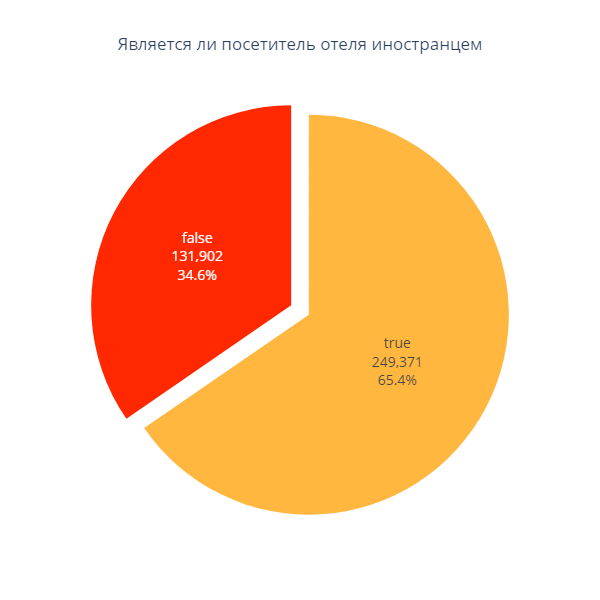

In [27]:
# Построение круговой диаграммы
figure_foreign_guest = go.Figure(data=[go.Pie(labels=df_hotels['foreign_guest'].value_counts().index,
                                              values=df_hotels['foreign_guest'].value_counts())])
# Стиль отображения
figure_foreign_guest.update_traces(textinfo='label+percent+value', # Содержимое подписи
                                   textfont_size=14, # Размер шрифта подписи
                                   pull=[0.05, 0.05], # Сдвиг сектора
                                   marker=dict(colors=["#FFB740", "#FF2800"]), # Цвета секторов
                                   showlegend=False) # Скрыть легенду
# Размер полотна
figure_foreign_guest.update_layout(autosize = False, width = 600, height = 600)
# Заголовок диаграммы
figure_foreign_guest.update_layout(title='Является ли посетитель отеля иностранцем',
                            title_x=0.5) # Расположение посередине
figure_foreign_guest.show("png")

Полученные значения показывают, что 65.3% отзывов получены от зарубежных гостей.

#### Признак "Теги из отзыва"

Данный признак содержит список тегов, прикрепленных посетителем к отзыву и требует преобразования.

In [28]:
# Получение полного списка тегов
tags_all = dict()
for tags in df_hotels['tags']:
    for tag in ast.literal_eval(tags):
        if tags_all.get(tag, 0) == 0:
            tags_all[tag] = 1
        else:
            tags_all[tag] = tags_all[tag] + 1

print(f'Количество уникольных тэгов: {len(tags_all)}')
# Сортируем словарь по значениям и берем первые 10 элементов
sorted_dict = dict(sorted(tags_all.items(), key=lambda item: item[1], reverse=True)[:10])

display(sorted_dict)

Количество уникольных тэгов: 2283


{' Leisure trip ': 309838,
 ' Submitted from a mobile device ': 227718,
 ' Couple ': 187141,
 ' Stayed 1 night ': 143230,
 ' Stayed 2 nights ': 98775,
 ' Solo traveler ': 79189,
 ' Stayed 3 nights ': 71056,
 ' Business trip ': 60442,
 ' Group ': 48491,
 ' Family with young children ': 45286}

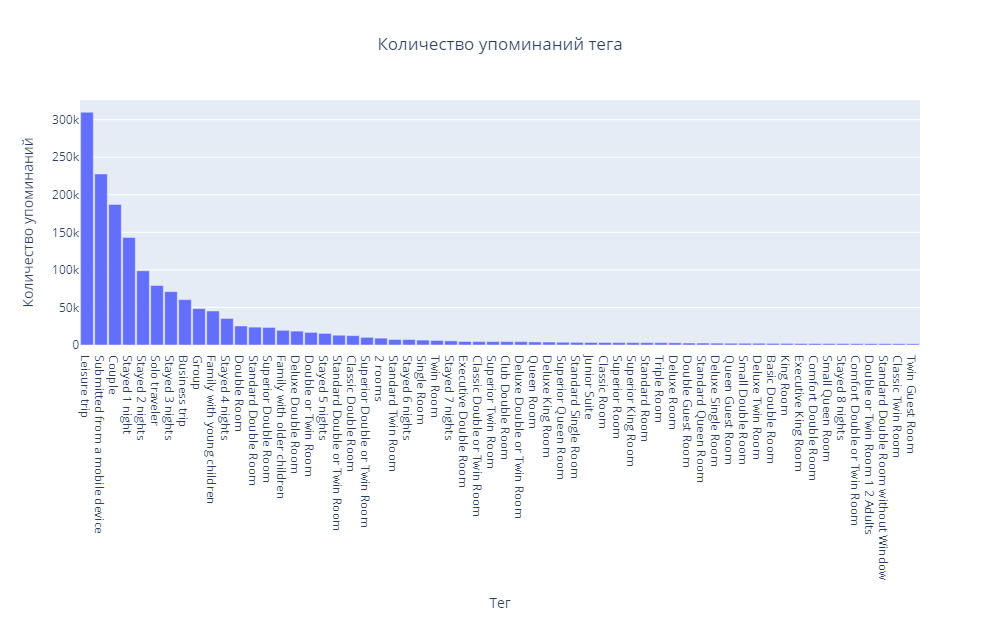

In [29]:
sorted_dict = dict(sorted(tags_all.items(), key=lambda item: item[1], reverse=True)[:60])
# Построение гистограммы
# Распределение категорий признака Требования к опыту
fig_tags = go.Figure(data=go.Bar(x=list(sorted_dict.keys()),
                                 y=list(sorted_dict.values())))
fig_tags.update_layout(autosize = False, width = 1000, height = 620, # Размер полотна
                                bargap=0.1) # Расстояние между столбцами
# Заголовк и подписи осей
fig_tags.update_layout(title='Количество упоминаний тега',
                                title_x=0.5, # Выравнивание заголовка посередине
                                xaxis_title='Тег', # Подпись Х
                                yaxis_title='Количество упоминаний') # Подпись Y
fig_tags.show('png')

В результате изучения состава тегов выделяем следующие признаки:
- Количество тегов отзыва (tags_count);
- Количество проведенных ночей (stayed_nights);
- Цель поездки (trip_type).

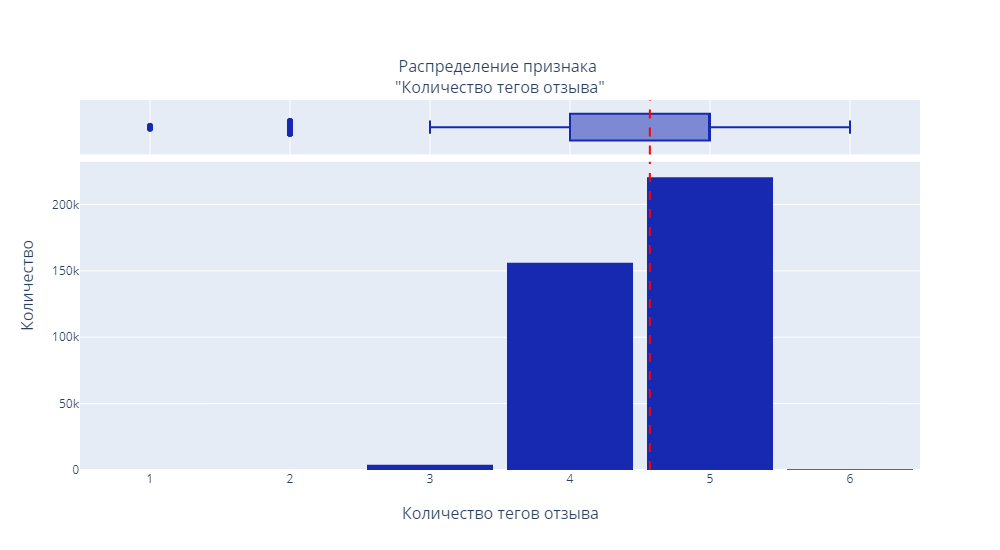

Статистические данные признака:


count    381273.00
mean          4.57
std           0.52
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           6.00
Name: tags_count, dtype: float64

In [30]:
# Генерация tags_count
df_hotels['tags_count'] = df_hotels['tags'].apply(lambda x: len(ast.literal_eval(x)))

col = 'tags_count'
# Инициализация полотна на два графика с общей осью X
fig_col = make_subplots(rows=2, cols=1,
                        shared_xaxes=True, # Общая ось Х
                        x_title='Количество тегов отзыва',
                        y_title='Количество',
                        row_heights=[0.15, 0.85], # Относительная высота полотен
                        subplot_titles=(f"Распределение признака <br>\"Количество тегов отзыва\"", ""),
                        vertical_spacing=0.02) # Высота разделителя
# Построение коробчатой диаграммы
fig_col.add_trace(go.Box(x=df_hotels[col],
                         marker_color = '#1729B0', # Цвет маркера
                         jitter=0.5, # Разнос точек выбросов по вертикали
                         name='',
                         showlegend=False),
                  row=1, col=1)
# Построение гистограммы
fig_col.add_trace(go.Histogram(x=df_hotels[col],
                               marker_color = '#1729B0', # Цвет маркера
                               name='Количество тегов отзыва', # Название набора данных
                               showlegend=False),
                  row=2, col=1)
# Построение линии среднего значения
fig_col.add_vline(x=df_hotels[col].mean(),
                  line=dict(color="Red", dash='dash')) # Стиль линии
# Размер полотна
fig_col.update_layout(autosize = False, width = 1000, height = 550,
                        bargap=0.1) # Расстояние между столбцами гистограммы
fig_col.show('png')

print('Статистические данные признака:')
display(df_hotels[col].describe().round(2))

In [31]:
# Генерация stayed_nights
def get_stayed_nights(tags: str):
    ''' Функция возвращает из строки тегов количество проведенных ночей.
    Args:
        tags (str): Строка, содержащая все теги
    Returns:
        int: Количество проведенных ночей, если строка не содержит
             регулярных выражений возвращает None
    '''
    reg_SN = r'Stayed (\d+) night'
    match = re.search(reg_SN, tags)
    if match:
        return (int(match.group(1)))
    else:
        return (np.nan)


df_hotels['stayed_nights'] = df_hotels['tags'].apply(get_stayed_nights)
# Заполнение отсутствующих значений модой признака
stayed_nights_mode = df_hotels['stayed_nights'].mode()[0]
df_hotels['stayed_nights'] = df_hotels['stayed_nights'].fillna(stayed_nights_mode)

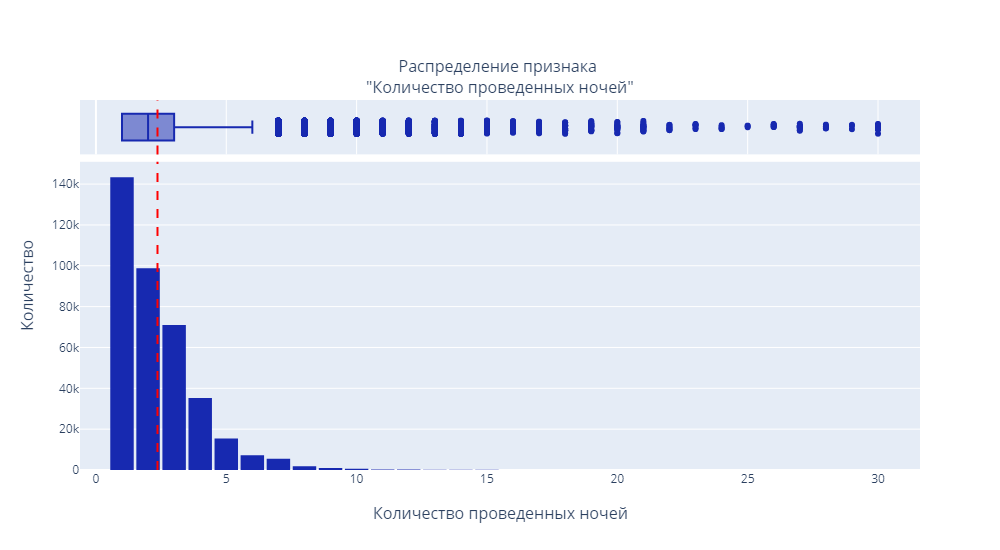

Статистические данные признака:


count    381273.00
mean          2.36
std           1.65
min           1.00
25%           1.00
50%           2.00
75%           3.00
max          30.00
Name: stayed_nights, dtype: float64

In [32]:
col = 'stayed_nights'
# Инициализация полотна на два графика с общей осью X
fig_col = make_subplots(rows=2, cols=1,
                        shared_xaxes=True, # Общая ось Х
                        x_title='Количество проведенных ночей',
                        y_title='Количество',
                        row_heights=[0.15, 0.85], # Относительная высота полотен
                        subplot_titles=(f"Распределение признака <br>\"Количество проведенных ночей\"", ""),
                        vertical_spacing=0.02) # Высота разделителя
# Построение коробчатой диаграммы
fig_col.add_trace(go.Box(x=df_hotels[col],
                         marker_color = '#1729B0', # Цвет маркера
                         jitter=0.5, # Разнос точек выбросов по вертикали
                         name='',
                         showlegend=False),
                  row=1, col=1)
# Построение гистограммы
fig_col.add_trace(go.Histogram(x=df_hotels[col],
                               marker_color = '#1729B0', # Цвет маркера
                               name='Количество проведенных ночей', # Название набора данных
                               showlegend=False),
                  row=2, col=1)
# Построение линии среднего значения
fig_col.add_vline(x=df_hotels[col].mean(),
                  line=dict(color="Red", dash='dash')) # Стиль линии
# Размер полотна
fig_col.update_layout(autosize = False, width = 1000, height = 550,
                      bargap=0.1) # Расстояние между столбцами гистограммы
fig_col.show('png')

print('Статистические данные признака:')
display(df_hotels[col].describe().round(2))

In [33]:
# Очистка от выбросов полученных признаков
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_positive_word_counts', log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews_reviewer_has_given', log_scale=True, left=3, right=3.5)

print(f'Результирующее число записей: {df_hotels.shape[0]}')

Результирующее число записей: 381243


In [34]:
# Генерация trip_type
def get_stayed_nights(tags: str):
    ''' Функция возвращает из строки тегов цель поездки.
    Args:
        tags (str): Строка, содержащая все теги
    Returns:
        int: Количество проведенных ночей, если строка не содержит
             регулярных выражений возвращает None
    '''
    if 'Business trip' in tags:
        return 'Business'
    elif 'Leisure trip' in tags:
        return 'Leisure'
    else:
        return np.nan


df_hotels['trip_type'] = df_hotels['tags'].apply(get_stayed_nights)
# Заполнение отсутствующих значений модой признака
trip_type_mode = df_hotels['trip_type'].mode()[0]
df_hotels['trip_type'] = df_hotels['trip_type'].fillna(trip_type_mode)

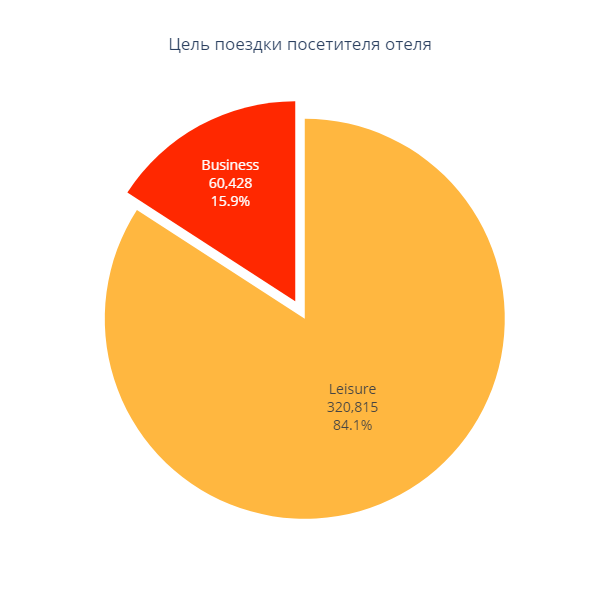

In [35]:
# Построение круговой диаграммы
figure_trip_type = go.Figure(data=[go.Pie(labels=df_hotels['trip_type'].value_counts().index,
                                          values=df_hotels['trip_type'].value_counts())])
# Стиль отображения
figure_trip_type.update_traces(textinfo='label+percent+value', # Содержимое подписи
                               textfont_size=14, # Размер шрифта подписи
                               pull=[0.05, 0.05], # Сдвиг сектора
                               marker=dict(colors=["#FFB740", "#FF2800"]), # Цвета секторов
                               showlegend=False) # Скрыть легенду
# Размер полотна
figure_trip_type.update_layout(autosize = False, width = 600, height = 600)
# Заголовок диаграммы
figure_trip_type.update_layout(title='Цель поездки посетителя отеля',
                            title_x=0.5) # Расположение посередине
figure_trip_type.show("png")

**Количество тегов отзыва**:
- распределение *ненормальное*;
- среднее значение 4.57;
- медиана 5;
- признак распределен в пределах от 1 до 6.

**Количество проведенных ночей**:
- распределение *ненормальное* (приближено к экспоненциальному);
- среднее значение 2.36;
- медиана 2;
- признак распределен в пределах от 1 до 30.

**Цель поездки** содержит 2 уникальных значения, Leisure (Туристическая поездка) - мода распределения (84% записей). Преобразуем в признак **Туристическая поездка**.

In [36]:
# Преобразвание признака
df_hotels['is_leisure_trip'] = np.where(df_hotels['trip_type'] == 'Leisure', True, False)
df_hotels.drop(['trip_type'], axis = 1, inplace=True)

#### Признак "Отрицательный отзыв рецензента"

Признак преобразуем в **Присутствует отрицательный отзыв** посредством проверки вхождения текста отзыва в список, включающий варианты отсутствия отрицательного отзыва. Отбираем подобные формулировки из 100 наиболее встречающихся. Остальные помечаются как имеющие отрицательный отзыв.

In [37]:
print(df_hotels['negative_review'].value_counts(normalize=True).head(100).index)

Index(['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
       ' ', ' N a', ' Breakfast', ' Location', ' Small room', ' All good',
       ' Everything', ' Nothing really', ' none', ' nothing ',
       ' No complaints', ' Nil', ' Nothing really ', ' Price', ' n a',
       ' Nothing to dislike', ' Nothing at all', ' Nothing at all ',
       ' Small rooms', ' None ', ' No complaints ', ' All good ', ' NA',
       ' Can t think of anything ', ' Expensive', ' Absolutely nothing ',
       ' Room size', ' Everything was perfect', ' Very small room',
       ' Nothing to dislike ', ' Staff', ' No', ' Everything was great ',
       ' Nothing to complain about ', ' Everything was perfect ', ' NOTHING',
       ' Leaving ', ' Leaving', ' Na', ' See above', ' Everything was great',
       ' Nothing not to like', ' small room', ' Liked everything',
       ' Can t think of anything', ' Not much', ' breakfast', ' location',
       ' Having to leave ', ' Non', ' Expensive breakfast',

In [38]:
# Список 
list_no_negative_review = ['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
                           ' ', ' N a', ' Nothing really', ' none', ' nothing ', ' No complaints', 
                           ' Nil', ' Nothing really ', ' n a', ' Nothing to dislike', ' Nothing at all', 
                           ' Nothing at all ', ' None ', ' No complaints ', ' All good ', ' NA', 
                           ' Absolutely nothing ', ' Can t think of anything ', ' Everything was perfect', 
                           ' Nothing to dislike ', ' No', ' Everything was great ', ' Everything was perfect ', 
                           ' Nothing to complain about ', ' NOTHING', ' Na', ' Nothing not to like', 
                           ' Everything was great', ' Can t think of anything', ' Liked everything', 
                           ' Non', ' Everything was good', ' All was good', ' Absolutely nothing', 
                           ' I liked everything', ' Nothing not to like ', ' Nothing to complain about', 
                           ' Everything was good ', ' No thing', ' I liked everything ', ' Everything was fine', 
                           ' Nothing in particular', ' nothing really', ' There was nothing I didn t like ']
# Генерация признака
df_hotels['has_negative_review'] = df_hotels['negative_review'].apply(lambda x: not(x in list_no_negative_review))

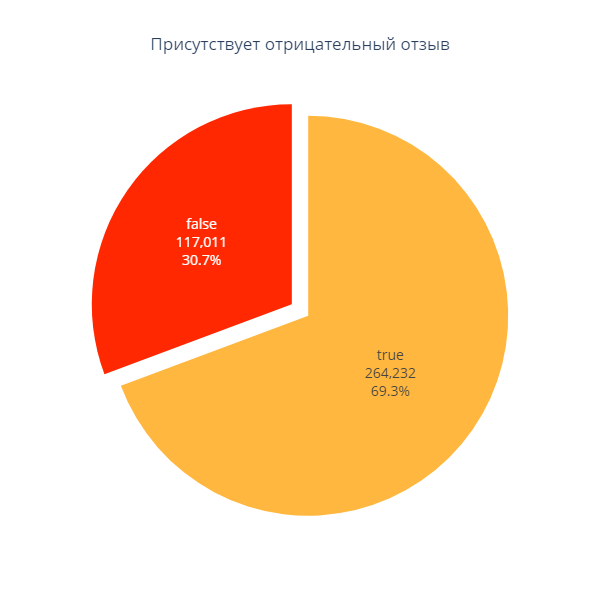

In [39]:
# Построение круговой диаграммы
figure_has_negative_review = go.Figure(data=[go.Pie(labels=df_hotels['has_negative_review'].value_counts().index,
                                                    values=df_hotels['has_negative_review'].value_counts())])
# Стиль отображения
figure_has_negative_review.update_traces(textinfo='label+percent+value', # Содержимое подписи
                                         textfont_size=14, # Размер шрифта подписи
                                         pull=[0.05, 0.05], # Сдвиг сектора
                                         marker=dict(colors=["#FFB740", "#FF2800"]), # Цвета секторов
                                         showlegend=False) # Скрыть легенду
# Размер полотна
figure_has_negative_review.update_layout(autosize = False, width = 600, height = 600)
# Заголовок диаграммы
figure_has_negative_review.update_layout(title='Присутствует отрицательный отзыв',
                                         title_x=0.5) # Расположение посередине
figure_has_negative_review.show("png")

**Присутствует отрицательный отзыв** содержит 2 уникальных значений, True (присутствует) - мода распределения (69,4% записей).

#### Признак "Положительный отзыв рецензента"

Признак преобразуем в **Присутствует положительный отзыв** посредством проверки вхождения текста отзыва в список, включающий варианты отсутствия положительного отзыва. Отбираем подобные формулировки из 100 наиболее встречающихся. Остальные помечаются как имеющие положительный отзыв.

In [40]:
print(df_hotels['positive_review'].value_counts(normalize=True).head(100).index)

Index(['No Positive', ' Location', ' Everything', ' location', ' Nothing',
       ' The location', ' Great location', ' Good location', ' Location ',
       ' Breakfast', ' Everything ', ' Friendly staff', ' Staff',
       ' Excellent location', ' Great location ', ' Location and staff',
       ' everything', ' Good location ', ' Nothing ', ' Comfy bed',
       ' The staff', ' The location ', ' good location', ' nothing',
       ' the location', ' Location was good', ' Location was great',
       ' Location staff', ' Good breakfast', ' ', ' All', ' Perfect location',
       ' Every thing', ' Clean', ' Excellent location ',
       ' Everything was perfect', ' great location', ' Location is great',
       ' Very friendly staff', ' Location is good', ' Comfortable bed',
       ' Cleanliness', ' Location location location', ' Breakfast was good',
       ' Everything was perfect ', ' Location was excellent',
       ' Central location', ' Great breakfast', ' Position',
       ' Staff and loc

In [41]:
# Список 
list_no_positive_review = ['No Positive', ' Nothing', ' Nothing ', ' nothing']
# Генерация признака
df_hotels['has_positive_review'] = df_hotels['positive_review'].apply(lambda x: not(x in list_no_positive_review))

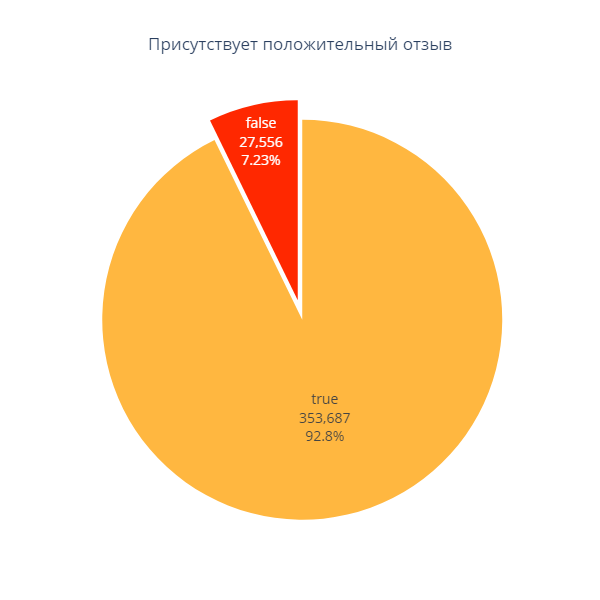

In [42]:
# Построение круговой диаграммы
figure_has_positive_review = go.Figure(data=[go.Pie(labels=df_hotels['has_positive_review'].value_counts().index,
                                                    values=df_hotels['has_positive_review'].value_counts())])
# Стиль отображения
figure_has_positive_review.update_traces(textinfo='label+percent+value', # Содержимое подписи
                                         textfont_size=14, # Размер шрифта подписи
                                         pull=[0.05, 0.05], # Сдвиг сектора
                                         marker=dict(colors=["#FFB740", "#FF2800"]), # Цвета секторов
                                         showlegend=False) # Скрыть легенду
# Размер полотна
figure_has_positive_review.update_layout(autosize = False, width = 600, height = 600)
# Заголовок диаграммы
figure_has_positive_review.update_layout(title='Присутствует положительный отзыв',
                                         title_x=0.5) # Расположение посередине
figure_has_positive_review.show("png")

**Присутствует положительный отзыв** содержит 2 уникальных значения, True (присутствует) - мода распределения (92,7% записей).  

#### Признак "Дата отзыва"

Признак преобразуем в **Квартал отзыва** и **Месяц отзыва**.

In [43]:
# Генерация признаков
df_hotels['review_month'] = df_hotels['review_date'].apply(lambda x: x.month)
df_hotels['review_quarter'] = df_hotels['review_date'].apply(lambda x: x.quarter)

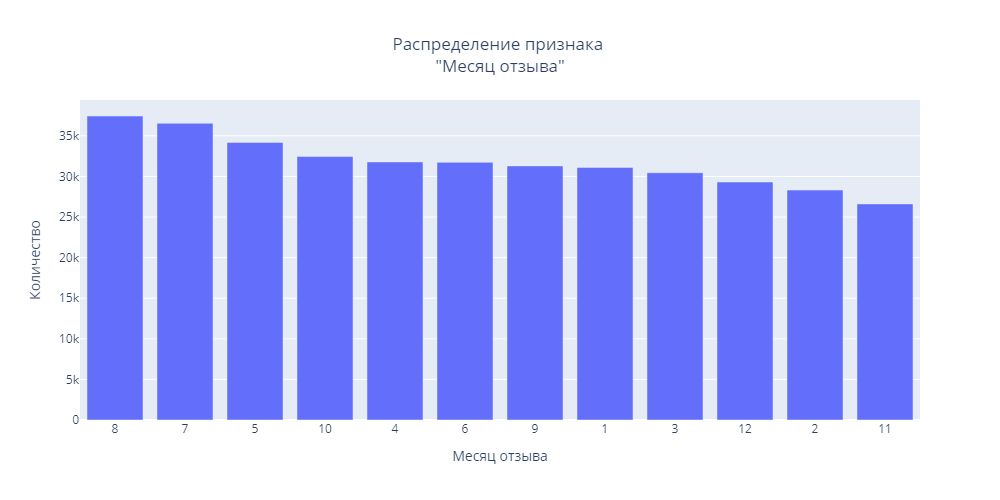

Статистические данные признака:


count    381243.000000
mean          6.488069
std           3.351822
min           1.000000
25%           4.000000
50%           7.000000
75%           9.000000
max          12.000000
Name: review_month, dtype: float64

Top значений (%):


review_month
8     9.82
7     9.59
5     8.97
10    8.51
4     8.34
6     8.32
9     8.21
1     8.16
3     7.99
12    7.69
Name: proportion, dtype: float64

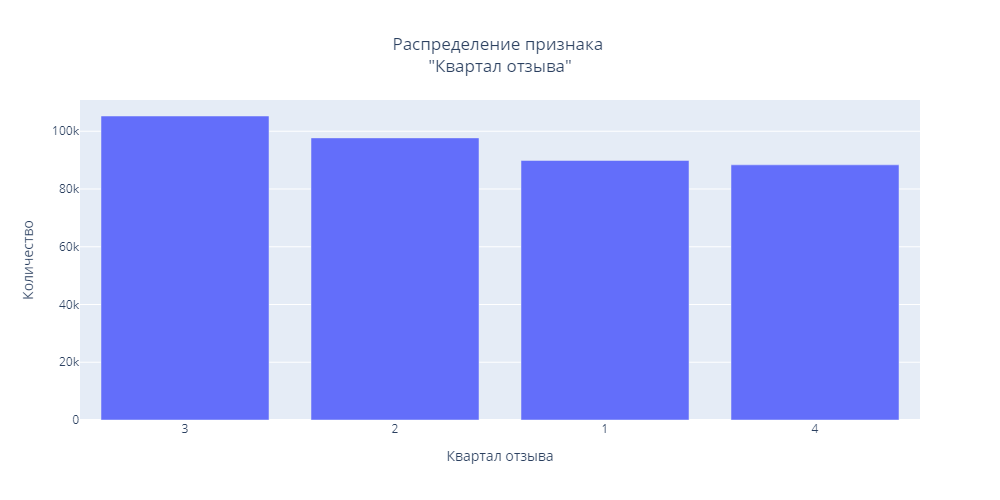

Статистические данные признака:


count    381243.000000
mean          2.503978
std           1.088634
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: review_quarter, dtype: float64

Top значений (%):


review_quarter
3    27.62
2    25.63
1    23.58
4    23.18
Name: proportion, dtype: float64

In [44]:
dict_col_name_rus = {'review_month': 'Месяц отзыва',
                     'review_quarter': 'Квартал отзыва'}
# Построение гистограммы распределения каждого числового признака
for col in dict_col_name_rus:
    df_tmp = df_hotels[col].value_counts().reset_index()
    #df_tmp[col] = df_tmp[col].apply(lambda x: x[:len_xtext]+'...' if len(x) > len_xtext else x)
    # Инициализация полотна
    fig_col = go.Figure(data=go.Bar(x=df_tmp[col].head(count_bar).index,
                                    y=df_tmp['count'].head(count_bar)))
    
    # Размер полотна
    fig_col.update_layout(autosize = False, width = 1000, height = 500)
    # Заголовок диаграммы
    fig_col.update_layout(title=f"Распределение признака <br>\"{dict_col_name_rus[col]}\"",
                          title_x=0.5, # Расположение посередине
                          xaxis_title=dict_col_name_rus[col], # Подпись Х
                          yaxis_title='Количество', # Подпись Y
                          xaxis=dict(tickvals=df_tmp[col].head(count_bar).index, # Оригинальные значения для оси X
                                     ticktext=df_tmp[col].head(count_bar))) # Новые подписи для оси X                   
    fig_col.show('png')
    
    print('Статистические данные признака:')
    display(df_hotels[col].describe())
    print('Top значений (%):')
    display(df_hotels[col].value_counts(normalize=True).head(10).round(4)*100)


В контексте задачи имеет смысл рассматривать полученные признаки в качестве номинальных категориальных, так как предполагается зависимость отзыва от периода/сезона его составления (близкого к посещению).

Максимальное количество отзывов составлено в августе/третьем квартале, минимальное - в ноябре/четвертом квартале.

### Очистка от исходных признаков и приведение типов

In [45]:
df_hotels.drop(['hotel_address', 'review_date', 'reviewer_nationality', 
                'negative_review', 'positive_review', 'tags'],
               axis = 1, inplace=True)

In [46]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381243 entries, 0 to 386495
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                381243 non-null  int64  
 1   average_score                               381243 non-null  float64
 2   hotel_name                                  381243 non-null  object 
 3   review_total_negative_word_counts           381243 non-null  int64  
 4   total_number_of_reviews                     381243 non-null  int64  
 5   review_total_positive_word_counts           381243 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  381243 non-null  int64  
 7   reviewer_score                              381243 non-null  float64
 8   days_since_review                           381243 non-null  int64  
 9   lat                                         381243 non-null  float64
 10  l

In [47]:
# Преобразование типов признаков
df_hotels['hotel_name'] = df_hotels['hotel_name'].astype('category')
df_hotels['country_city'] = df_hotels['country_city'].astype('category')
df_hotels['country'] = df_hotels['country'].astype('category')
df_hotels['review_month'] = df_hotels['review_month'].astype('category')
df_hotels['review_quarter'] = df_hotels['review_quarter'].astype('category')
df_hotels['stayed_nights'] = df_hotels['stayed_nights'].astype('int64')
# Удаление дубликатов
cnt = df_hotels.shape[0]
df_hotels = df_hotels.drop_duplicates(ignore_index=True)
print(f'Удалено дубликатов: {cnt - df_hotels.shape[0]}')
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df_hotels.isnull().sum().sum()}')
df_hotels.info()

Удалено дубликатов: 20
Количество пропущенных значений: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381223 entries, 0 to 381222
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                381223 non-null  int64   
 1   average_score                               381223 non-null  float64 
 2   hotel_name                                  381223 non-null  category
 3   review_total_negative_word_counts           381223 non-null  int64   
 4   total_number_of_reviews                     381223 non-null  int64   
 5   review_total_positive_word_counts           381223 non-null  int64   
 6   total_number_of_reviews_reviewer_has_given  381223 non-null  int64   
 7   reviewer_score                              381223 non-null  float64 
 8   days_since_review                           381223 non-null  int64   
 9   l

На данном этапе проведена очистка данных, выполнен одномерный статистический анализ, проектирование признаков, приведены их типы.  
Объем статистической выборки составляет 386476 отзывов по 21 признаку.

---

Проверить гипотезу зависимости оценки от названия отеля!!!

## Исследование взаимосвязи данных, выдвижение и проверка гипотез

In [48]:
# Расшифровка признаков полученной выборки
dict_col_name = {'additional_number_of_scoring': 'Количество действительных оценок без проверки', 
                 'average_score': 'Средний балл отеля за последний год',
                 'hotel_name': 'Название отеля',
                 'review_total_negative_word_counts': 'Общее количество слов отрицательного отзыва',
                 'total_number_of_reviews': 'Общее количество действительных отзывов отеля',
                 'review_total_positive_word_counts': 'Общее количество слов положительного отзыва',
                 'total_number_of_reviews_reviewer_has_given': 'Количество отзывов отеля',
                 'reviewer_score': 'Оценка рецензента', # Предсказываемый параметр
                 'days_since_review': 'Количество дней между датой проверки и датой очистки', 
                 'lat': 'Географическая широта отеля',
                 'lng': 'Географическая долгота отеля', 
                 'country_city': 'Город расположения отеля', 
                 'country': 'Страна расположения отеля',       
                 'foreign_guest': 'Зарубежный гость', 
                 'tags_count': 'Количество тегов отзыва', 
                 'stayed_nights': 'Количество проведенных ночей', 
                 'is_leisure_trip': 'Поездка туристическая',       
                 'has_negative_review': 'Присутствует отрицательный отзыв', 
                 'has_positive_review': 'Присутствует положительный отзыв', 
                 'review_month': 'Месяц оставления отзыва',       
                 'review_quarter': 'Квартал оставления отзыва'}
# Список количественных признаков
#signs_num = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
#             'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
#             'days_since_review', 'lat', 'lng', 'tags_count', 'stayed_nights', 'reviewer_score']
# Список категориальных признаков
#signs_cat = ['hotel_name', 'country_city', 'country', 'foreign_guest', 'trip_type', 
#             'has_negative_review', 'has_positive_review', 'review_month', 'review_quarter']

---

## Кодирование и отбор признаков

### Кодирование признаков

Выбор метода кодирования:
- 'hotel_name' - 1493 уникальных значения, преобразуем бинарным кодированием;
- 'country_city' - 6 уникальных значений, преобразуем однократным кодированием;
- 'country' - 6 уникальных значений, преобразуем однократным кодированием;
- *'foreign_guest'* - bool, кодирование не требуется;
- 'trip_type' - 2 уникальных значения, преобразуем в bool;
- *'has_negative_review'* - bool, кодирование не требуется; 
- *'has_positive_review'* - bool, кодирование не требуется;
- 'review_month' - 12 уникальных значений, преобразуем однократным кодированием;
- 'review_quarter' - 4 уникальных значеня, преобразуем однократным кодированием.

In [49]:
# Бинарное кодирование
coded_cols = ['hotel_name']
bin_encoder = ce.BinaryEncoder(cols=coded_cols)
type_bin = bin_encoder.fit_transform(df_hotels[coded_cols])
df_hotels_coded = pd.concat([df_hotels, type_bin], axis=1)
df_hotels_coded.drop(coded_cols, axis = 1, inplace=True)

# Однократное кодирование
coded_cols = ['country_city', 'country', 'review_month', 'review_quarter']
one_hot_encoder = ce.OneHotEncoder(cols=coded_cols)
type_bin = one_hot_encoder.fit_transform(df_hotels[coded_cols])
df_hotels_coded = pd.concat([df_hotels_coded, type_bin], axis=1)
# Удаление исходных признаков
df_hotels_coded.drop(coded_cols, axis = 1, inplace=True)

In [50]:
df_hotels_coded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381223 entries, 0 to 381222
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                381223 non-null  int64  
 1   average_score                               381223 non-null  float64
 2   review_total_negative_word_counts           381223 non-null  int64  
 3   total_number_of_reviews                     381223 non-null  int64  
 4   review_total_positive_word_counts           381223 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  381223 non-null  int64  
 6   reviewer_score                              381223 non-null  float64
 7   days_since_review                           381223 non-null  int64  
 8   lat                                         381223 non-null  float64
 9   lng                                         381223 non-null  float64
 

total_number_of_reviews - additional_number_of_scoring
country_city_5 - lng
country_city_6 - lat
country_1 - country_city_1
country_2 - country_city_2
country_3 - country_city_3
country_4 - country_city_4
country_5 - lng
country_5 - country_city_5
country_6 - lat
country_6 - country_city_6


<Axes: >

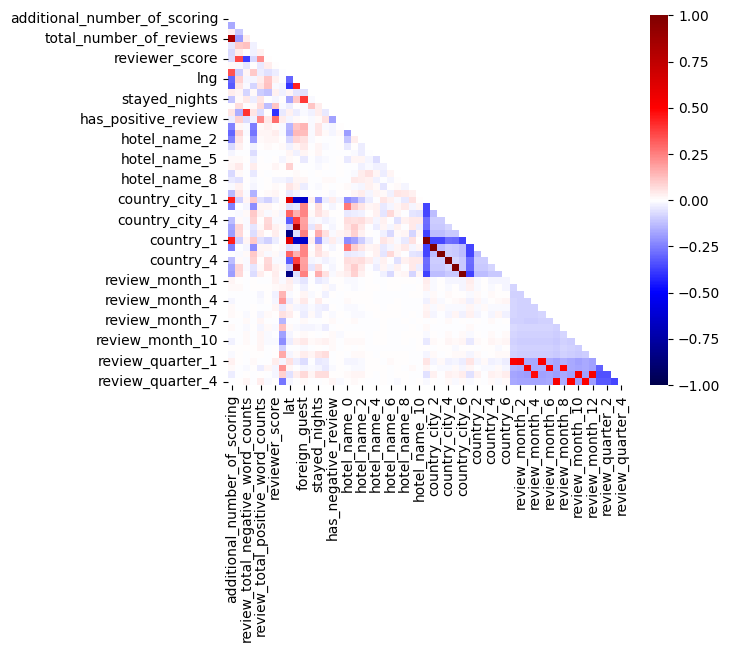

In [51]:
df_corr = df_hotels_coded.corr(method='pearson',
                         numeric_only=True)
# Вычисление списка пар сильно коррелирующих признаков
for i in range(1, df_corr.shape[0]):
    for j in range(0, i):
        if df_corr.iloc[i, j] >= 0.7 or df_corr.iloc[i, j] <= -0.7:
            print(f'{df_corr.index[i]} - {df_corr.columns[j]}')
            
# Матрица корреляций винных обзоров
sns.heatmap(df_hotels_coded.corr(numeric_only=True),
            annot=False, # Подпись данных
            vmin=-1, vmax=1,
            center=0,
            cmap='seismic',
            mask=np.triu(df_hotels_coded.corr(numeric_only=True)))

Исходя из смыслового содержания признаков в качестве удаляемых в паре Страна - Страна_город выбираем признак страны, так как он более общий. Широта и долгота сильно коррелируют только с частью закодированного признака Страна_город, поэтому в качестве удаляемых выбираем признаки Широты и долготы.
В паре 'Количество действительных оценок без проверки' (additional_number_of_scoring) - 'Общее количество действительных отзывов отеля' (total_number_of_reviews) оставляем признак общего количества действительных отзывов отеля.

In [52]:
# Удаление признаков
del_cols = ['lng', 'lat', 
            'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6',
            'additional_number_of_scoring']
df_hotels_coded.drop(del_cols, axis = 1, inplace=True)

In [53]:
# Удаление признаков
del_cols = ['hotel_name_0', 'hotel_name_1', 'hotel_name_2', 
            'hotel_name_3', 'hotel_name_4', 'hotel_name_5', 
            'hotel_name_6', 'hotel_name_7', 'hotel_name_8',
            'hotel_name_9', 'hotel_name_10',
            'review_quarter_1', 'review_quarter_2', 'review_quarter_3', 'review_quarter_4']
df_hotels_coded.drop(del_cols, axis = 1, inplace=True)

<Axes: >

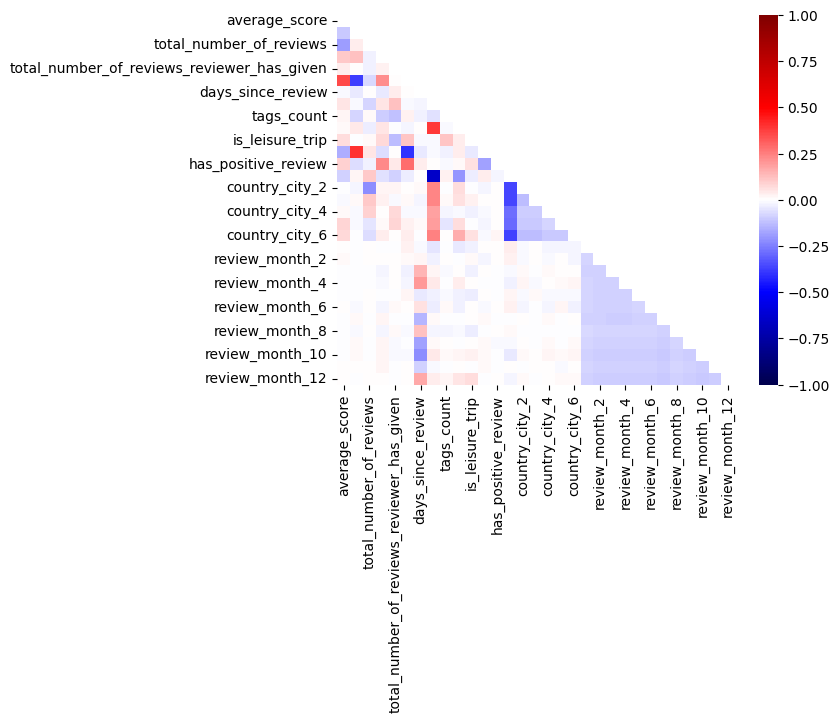

In [54]:
df_corr = df_hotels_coded.corr(method='pearson',
                         numeric_only=True)
# Вычисление списка пар сильно коррелирующих признаков
for i in range(1, df_corr.shape[0]):
    for j in range(0, i):
        if df_corr.iloc[i, j] >= 0.7 or df_corr.iloc[i, j] <= -0.7:
            print(f'{df_corr.index[i]} - {df_corr.columns[j]}')
            
# Матрица корреляций винных обзоров
sns.heatmap(df_hotels_coded.corr(numeric_only=True),
            annot=False, # Подпись данных
            vmin=-1, vmax=1,
            center=0,
            cmap='seismic',
            mask=np.triu(df_hotels_coded.corr(numeric_only=True)))

Для уменьшения влияния выбросов на модель проведем нормализацию данных

In [55]:
# Нормализация данных
lst_col = ['average_score', 'review_total_negative_word_counts',
           'total_number_of_reviews', 'review_total_positive_word_counts',
           'total_number_of_reviews_reviewer_has_given', 'tags_count',
           'stayed_nights']
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(df_hotels_coded[lst_col])
df_r = pd.DataFrame(df_r, columns=lst_col)
for col in lst_col:
    df_hotels_coded[col] = df_r[col]

---

## Формирование и оценка модели

reviewer_score - предсказываемый параметр

In [56]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df_hotels_coded.drop(['reviewer_score'], axis = 1)
y = df_hotels_coded['reviewer_score']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.13346024688422034


In [57]:
# непрерывные признаки
num_cols = ['average_score',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'tags_count',
            'stayed_nights']

# категориальные признаки
cat_cols = ['foreign_guest',
            'is_leisure_trip',
            'has_negative_review',
            'has_positive_review',
            'country_city_1',
            'country_city_2',
            'country_city_3',
            'country_city_4',
            'country_city_5',
            'country_city_6',
            'review_month_1',
            'review_month_2',
            'review_month_3',
            'review_month_4',
            'review_month_5',
            'review_month_6',
            'review_month_7',
            'review_month_8',
            'review_month_9',
            'review_month_10',
            'review_month_11',
            'review_month_12']

<Axes: >

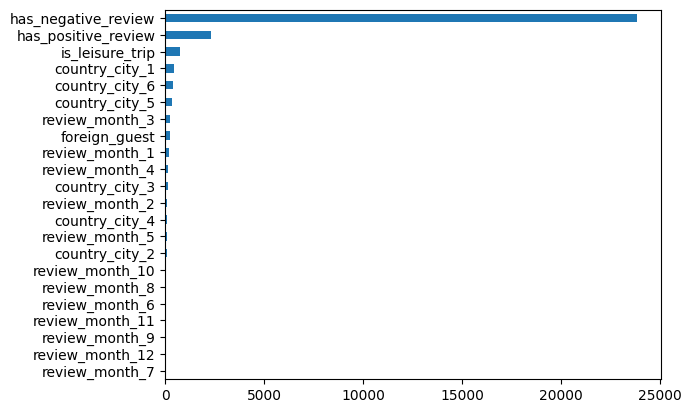

In [58]:
y=y.astype('int')
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(abs(X[cat_cols]), y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

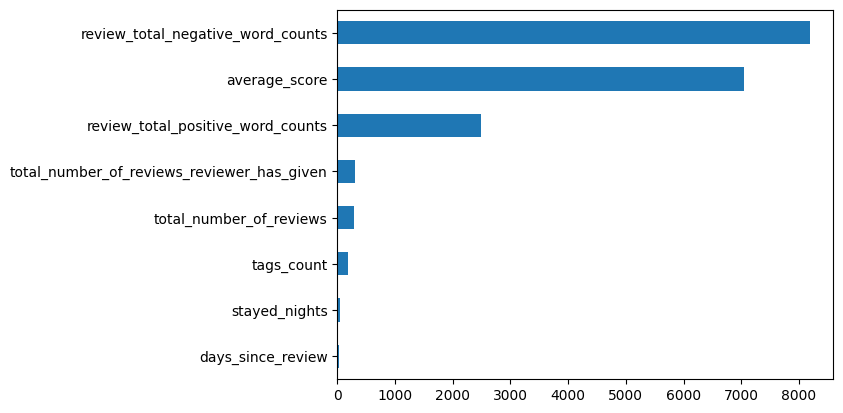

In [59]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Мало - удаляем:  
review_month_1-12 переделать в high mid & low  

In [60]:
df_hotels_coded_2 = df_hotels_coded.copy()
df_hotels_coded_2['month_high'] = df_hotels_coded_2['review_month_8'] + df_hotels_coded_2['review_month_7'] + df_hotels_coded_2['review_month_5']
df_hotels_coded_2['month_mid'] = df_hotels_coded_2['review_month_10'] + df_hotels_coded_2['review_month_4'] + df_hotels_coded_2['review_month_6'] + \
                                 df_hotels_coded_2['review_month_9'] + df_hotels_coded_2['review_month_1'] + df_hotels_coded_2['review_month_3']
df_hotels_coded_2['month_low'] = df_hotels_coded_2['review_month_12'] + df_hotels_coded_2['review_month_2'] + df_hotels_coded_2['review_month_11']



del_cols = ['review_month_11', 
            'review_month_1', 'review_month_5', 'review_month_9', 
            'review_month_2', 'review_month_6', 'review_month_10',
            'review_month_3', 'review_month_7',
            'review_month_4', 'review_month_8', 'review_month_12']
df_hotels_coded_2.drop(del_cols, axis = 1, inplace=True)

In [61]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df_hotels_coded_2.drop(['reviewer_score'], axis = 1)
y = df_hotels_coded_2['reviewer_score']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=300)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.1332112521927899
